<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Normalisation

 Normalization using train data mean and train data standard dev to both training and test data.

In [13]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("ylecun/mnist")

def format_data(split, mean=None, std=None):
    images = np.array([np.array(img).flatten() for img in split["image"]])
    if mean is None or std is None:
        mean = np.mean(images, axis=0)
        std = np.std(images, axis=0)
    std_copy = std.copy()
    std_copy[std_copy == 0] = 1.0
    X = (images - mean) / std_copy
    y = np.array(split["label"])
    return X, y, mean, std

# Q2. Linear Classifier

The accuracy of a linear regression based classifier , using quadratic loss and learning rate 0.001 is 0.40, however the training is not really stable as linear regression without any function applied on the output is unsuitable for classification (and quadratic loss too).

In [26]:
X_train, y_train, train_mean, train_std = format_data(dataset["train"])
X_test, y_test, _, _ = format_data(dataset["test"], train_mean, train_std)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [25]:
np.unique(y_train, return_counts=True)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
np.random.seed(0)
idxs = []
for c in range(10):
    class_idxs = np.where(y_train == c)[0]
    chosen = np.random.choice(class_idxs, size=1000, replace=True)
    idxs.append(chosen)
idxs = np.concatenate(idxs)
np.random.shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

New shape of X_train: (10000, 784)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class shallowNN(nn.Module):
    def __init__(self, k = 1, p = 0.1):
        super(shallowNN, self).__init__()
        self.fc1 = nn.Linear(784, k)  
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        self.dropout = nn.Dropout(p)
        self.fc2 = nn.Linear(k, 10) 
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)  
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = shallowNN()

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:02<00:00, 33.51it/s]


Trained model with k=1, p=0.0


100%|██████████| 80/80 [00:03<00:00, 26.45it/s]


Trained model with k=5, p=0.0


100%|██████████| 80/80 [00:03<00:00, 22.92it/s]


Trained model with k=15, p=0.0


100%|██████████| 80/80 [00:05<00:00, 15.00it/s]


Trained model with k=35, p=0.0


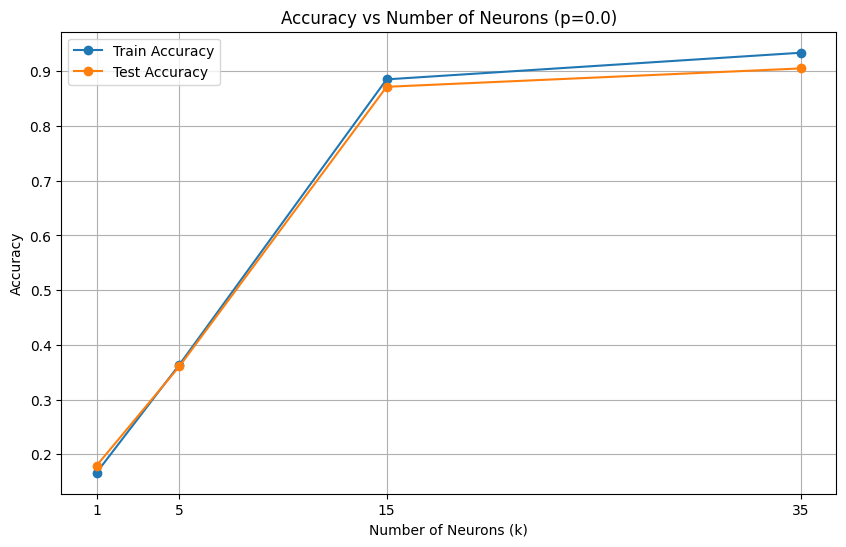

In [ ]:
kvals = [1, 5, 15, 35]
# assignment grid P has p=1.0 meaning 'no dropout' (typo in prompt). Map it to 0.0 for PyTorch.
pvals = [0.1, 0.25, 0.5, 1.0]
import matplotlib.pyplot as plt
import tqdm

train_acc = {}
test_acc = {}
torch.manual_seed(0)

# local init function (applied to each model before training)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

for p in pvals:
    for k in kvals:
        # map assignment's p to PyTorch dropout probability
        dropout_p = 0.0 if p == 1.0 else p
        model = shallowNN(k=k, p=dropout_p)
        model.apply(init_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # larger LR to help convergence
        train_acc_epoch = 0.0
        test_acc_epoch = 0.0
        epochs = 500
        for epoch in tqdm.tqdm(range(epochs)):
            model.train()
            inputs = torch.tensor(X_train, dtype=torch.float32)
            labels = torch.tensor(y_train, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)  # logits
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                model.eval()
                train_acc_epoch = (model(inputs).argmax(dim=1) == labels).float().mean().item()
                test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
                test_acc_epoch = (test_outputs.argmax(dim=1) == torch.tensor(y_test, dtype=torch.long)).float().mean().item()
                print(f"k={k}, p={p} (dropout={dropout_p}), epoch={epoch+1}, loss={loss.item():.4f}, train_acc={train_acc_epoch:.4f}, test_acc={test_acc_epoch:.4f}")
                model.train()
        train_acc[(k, p)] = train_acc_epoch
        test_acc[(k, p)] = test_acc_epoch
        print(f"Trained model with k={k}, p={p}")
    
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [train_acc[(k, p)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [test_acc[(k, p)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('Number of Neurons (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Neurons (p={p})')
    plt.legend()
    plt.grid()
    plt.show()


In [36]:
print(train_acc)

{(1, 0.0): 0.1662999987602234, (5, 0.0): 0.36390000581741333, (15, 0.0): 0.8853999972343445, (35, 0.0): 0.9340999722480774}


Trying other values of k

In [38]:
train_acc

{(50, 0.0): 0.9519000053405762,
 (75, 0.0): 0.9578999876976013,
 (100, 0.0): 0.9642999768257141}

I think there might be a typo in the question, because no dropout regularisation would correpsond to p = 0, not p = 1 as mention in the question. With p = 0.0, as k (the number of units )increases, the training accuracy and test accuracy both improve. At no k in the current set, the training accuracy has become 100%